In [73]:
import uproot
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers

NUMEPOCHS = 100
PHASEMAX = 20


def GetData(filename, treename="timing"):
    '''
    Returns TFile as a pandas dataframe
    '''
    file = uproot.open(filename)
    tree = file[treename]
    npdf = tree.arrays(library="np")
    df =  pd.DataFrame(npdf, columns=npdf.keys())
    return df

def PlotTraces(traces, n=10):
    '''
    plot n random traces from the traces array
    '''
    import matplotlib.pyplot as plt
    time = np.arange(0, 600.0, 2.0)
    fig = plt.figure(figsize=(10, 5))
    for i in range(n):
        rand_idx = np.random.randint(0, traces.shape[0])
        plt.plot(time, traces[rand_idx][:], label="Trace {}".format(rand_idx))
    plt.plot([0, 600], [0, 0], 'k-', lw=2)
    plt.grid()
    plt.xlabel("Time (ns)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.show()

def GetTraces(values):
    traces = np.zeros((values.shape[0], 300))
    for i in range(values.shape[0]):
        trace = np.array(values[i]).reshape(300, 1)
        traces[i][:] = trace[:, 0]
    return traces

def NormalizeTraces(traces):
    ''' 
    Normailze traces to have a max of 1 and a min of 0
    '''
    
    for i in range(traces.shape[0]):
        min_before_peak = np.min(traces[i][:100])
        traces[i][:] = traces[i][:] - min_before_peak
        
    return traces / np.max(traces, axis=1)[:, None]

def OneHotEndocePileup(pileup):
    pileup_one_hot = np.zeros((pileup.shape[0], 2))
    for i in range(pileup.shape[0]):
        if pileup[i]:
            pileup_one_hot[i][:] = [1, 0]
        else:
            pileup_one_hot[i][:] = [0, 1]
    return pileup_one_hot

def GetPhases(phases):
    phase = np.zeros((phases.shape[0], 1))
    for i in range(phases.shape[0]):
        if phases[i] > 0:
            phase[i] = phases[i]
        else:
            phase[i] = 0.0
    return phase
    
def PlotPhasesAndTrace(traces, phases, onehot, n =10):
    import matplotlib.pyplot as plt
    time = np.arange(0, 600.0, 2.0)
    ygrid = n//5
    if n%5 != 0:
        ygrid += 1
    fig, ax = plt.subplots(ygrid, 5 ,figsize=(20, ygrid*3), sharex=True, sharey=True)
    for i in range(n):
        rand_idx = np.random.randint(0, traces.shape[0])
        ax[i//5, i%5].plot(time, traces[rand_idx][:], label="Trace {}".format(rand_idx))
        ax[i//5, i%5].plot([0, 600], [0, 0], 'k-', lw=2)
        if i%5 == 0:
            ax[i//5, i%5].set_ylabel("Amplitude (mV)")
        if i//5 == ygrid-1:
            ax[i//5, i%5].set_xlabel("Time (ns)")
            
        ax[i//5, i%5].set_xlim(0, 600)
        ax[i//5, i%5].set_ylim(-0.1, 1.15)
        ax[i//5, i%5].text(0.05, 0.9, "Trace #{}".format(rand_idx), fontsize=10, color='black', transform=ax[i//5, i%5].transAxes,fontweight='bold')
        if onehot[rand_idx][0]:
            ax[i//5, i%5].text(0.55, 0.9, "Shift: {0:.2f} ns".format(phases[rand_idx][0]), fontsize=10, color='blue', transform=ax[i//5, i%5].transAxes)
        else:
            ax[i//5, i%5].text(0.55, 0.9, "No Pileup", fontsize=10, color='red', transform=ax[i//5, i%5].transAxes)
    plt.show()
    
def PulseNet():
    
    #shared base model
    input = layers.Input(shape=(300,1))
    conv1 = layers.Conv1D(kernel_size=64, filters=300, activation='tanh')(input)
    max1 = layers.MaxPooling1D(pool_size=100)(conv1)
    conv2 = layers.Conv1D(kernel_size=1, filters=150, activation='relu')(max1)
    max2 = layers.MaxPooling1D(pool_size=1)(conv2)
    conv3 = layers.Conv1D(kernel_size=1, filters=256, activation='relu')(max2)
    max3 = layers.MaxPooling1D(pool_size=1)(conv3)
    conv4 = layers.Conv1D(kernel_size=2, filters=300, activation='relu', padding='same')(max3)
    max4 = layers.MaxPooling1D(pool_size=1)(conv4)

    # phase sub model
    phase_flat1 = layers.Flatten()(max4)
    phase_dense1 = layers.Dense(264, activation='relu')(phase_flat1)
    phase_dense2 = layers.Dense(128, activation='relu')(phase_dense1)
    phase_dense3 = layers.Dense(64, activation='relu')(phase_dense2)
    phase_output = layers.Dense(1, activation='linear')(phase_dense3)
    
    # amplitude sub model
    amp_flat1 = layers.Flatten()(max4)
    amp_dense1 = layers.Dense(264, activation='relu')(amp_flat1)
    amp_dense2 = layers.Dense(128, activation='relu')(amp_dense1)
    amp_dense3 = layers.Dense(64, activation='relu')(amp_dense2)
    amp_output = layers.Dense(1, activation='linear')(amp_dense3)
    
    # pileup sub model
    pulse1 = layers.Dense(300, activation='tanh')(max4[:,0,:])
    pulse2 = layers.Dense(300, activation='tanh')(max4[:,1,:])
    stack = tf.stack([pulse1, pulse2], axis=1)
    rnn = layers.Bidirectional(layers.LSTM(300, return_sequences=True))(stack)
    dense1a = layers.Dense(300, activation='relu')(rnn[:,0,:])
    dense2a = layers.Dense(300, activation='relu')(rnn[:,1,:])
    dense1b = layers.Dense(300, activation='relu')(dense1a)
    dense2b = layers.Dense(300, activation='relu')(dense2a)
    stack_final = tf.stack([dense1b, dense2b], axis=1)
    dense_out1 = layers.Dense(128, activation='relu')(stack_final)
    pileup_output = layers.Dense(300, activation='linear')(dense_out1)

    phase_amp_output = tf.stack([phase_output, amp_output], axis=1)
    # output = tf.stack([phase_output, amp_output, pileup_output], axis=1)
    model = models.Model(inputs=input, outputs=[phase_amp_output, pileup_output])
    model.summary()
    return model


def PhaseNet():
    input = layers.Input(shape=(300,1))
    conv1 = layers.Conv1D(kernel_size=10, filters=64, activation='tanh')(input)
    max1 = layers.MaxPooling1D(pool_size=1)(conv1)
    conv2 = layers.Conv1D(kernel_size=10, filters=64, activation='relu')(max1)
    max2 = layers.MaxPooling1D(pool_size=1)(conv2)
    conv3 = layers.Conv1D(kernel_size=1, filters=64, activation='relu')(max2)
    max3 = layers.MaxPooling1D(pool_size=1)(conv3)
    conv4 = layers.Conv1D(kernel_size=2, filters=64, activation='relu', padding='same')(max3)
    max4 = layers.MaxPooling1D(pool_size=10)(conv4)
    
    flat1 = layers.Flatten()(max4)
    dense1 = layers.Dense(264, activation='relu')(flat1)
    dense2 = layers.Dense(128, activation='relu')(dense1)
    dense3 = layers.Dense(64, activation='relu')(dense2)
    output = layers.Dense(1, activation='linear')(dense3)
    
    model = models.Model(inputs=input, outputs=output)
    model.summary()
    
    return model


pdf = GetData("ysoTracesWithPileup.root")
pdf = pdf[pdf["trace"].apply(lambda x: x.shape[0] == 300)].reset_index(drop=True)
pile_up_one_hot = OneHotEndocePileup(pdf["pileup"].values)
phase_shifts = GetPhases(pdf["phase"].values)
traces = GetTraces(pdf["trace"].values)

In [74]:
import tensorflow as tf
from tensorflow import keras

class PulseSplit(layers.Layer):
    def call(self,inputs):
      return tf.split(inputs, 2, axis=2)
    
class TraceEncoder(layers.Layer):
  
    def __init__(self, name="encoder"):
      super(TraceEncoder, self).__init__(name=name)
      
      self.fullyConnectedCNN = layers.Conv1D(kernel_size=300, filters=64, activation='tanh', name="encoder-fullyConnectedCNN")
      self.maxPooling1 = layers.MaxPooling1D(pool_size=1, name="encoder-maxPoolingCNN")
      self.conv1 = layers.Conv1D(kernel_size=1, filters=300, activation='relu', name="encoder-conv1")
      self.maxPooling2 = layers.MaxPooling1D(pool_size=1, name="encoder-maxPooling1")
      self.flatten = layers.Flatten(name="encoder-flatten")
      self.dense1 = layers.Dense(300, activation='relu', name="encoder-dense1")
      self.denseout = layers.Dense(300, activation='linear', name="encoder-output")
      
    def call(self, input):
        x = self.fullyConnectedCNN(input)
        x = self.maxPooling1(x)
        x = self.conv1(x)
        x = self.maxPooling2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.denseout(x)
        return tf.expand_dims(x, axis=2)
    
class TraceDecoder(layers.Layer):
  
  def __init__(self, name="decoder", **kwargs):
    super(TraceDecoder, self).__init__(name=name, **kwargs)
    self.conv1 = layers.Conv1D(kernel_size=300, filters=64, activation='tanh', name="decoder-fullyConnectedCNN")
    self.maxPooling1 = layers.MaxPooling1D(pool_size=1, name="decoder-maxPoolingCNN")
    self.conv4 = layers.Conv1D(kernel_size=1, filters=128, activation='relu', name="decoder-conv1")
    self.max4 = layers.MaxPooling1D(pool_size=1, name="decoder-maxPooling1")
    self.pulsespliter = PulseSplit()
    self.latent_dense1 = layers.Dense(150, activation='relu', name="decoder-latentDense1")
    self.latent_dense2 = layers.Dense(150, activation='relu', name="decoder-latentDense2")
    self.denseout = layers.Dense(300, activation='linear', name="decoder-output")
    self.rnn = layers.Bidirectional(layers.LSTM(300, return_sequences=True), name="decoder-rnn")

      
  def call(self, input):
      x = self.conv1(input)
      x = self.maxPooling1(x)
      x = self.conv4(x)
      x = self.max4(x)
      x = self.latent_dense1(x)
      x = self.latent_dense2(x)
      x = self.rnn(x)
      x1, x2 = self.pulsespliter(x)
      x1 = self.denseout(x1)
      x2 = self.denseout(x2)
      y = tf.stack([x1, x2], axis=1)    
      return y 

# class PulseNet(keras.Model):
  
#   def __init__(self, task,**kwargs):
#     super(PulseNet, self).__init__(**kwargs)
#     self.encoder = TraceEncoder()
#     self.decoder = TraceDecoder()
#     self.trained = False 
  
#   def call(self, input):
#     x = self.encoder(input)
#     x = self.decoder(x)
#     return x
  
class PhaseNet(keras.Model):
  
  def __init__(self, task,**kwargs):
    super(PhaseNet, self).__init__(**kwargs)
    self.encoder = TraceEncoder()
    self.decoder = TraceDecoder()
    self.trained = False 
  
  def call(self, input):
    x = self.encoder(input)
    x = self.decoder(x)
    return x

class AmplitudeNet(keras.Model):
  
  def __init__(self, task,**kwargs):
    super(AmplitudeNet, self).__init__(**kwargs)
    self.encoder = TraceEncoder()
    self.decoder = TraceDecoder()
    self.trained = False
  
  def call(self, input):
    x = self.encoder(input)
    x = self.decoder(x)
    return x

class TaggerNet(keras.Model):
  
  def __init__(self, task,**kwargs):
    super(TaggerNet, self).__init__(**kwargs)
    self.encoder = TraceEncoder()
    self.decoder = TraceDecoder()
    self.trained = False
  
  def call(self, input):
    return input


In [75]:
# PlotPhasesAndTrace(pdf["trace"].values, phase_shifts, pile_up_one_hot, n=20)

In [76]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# fig = plt.figure(figsize=(10, 10))
# plt.plot(ytest, ytest_pred, 'o', color='black',alpha=0.5)
# plt.plot([0, 100], [0, 100], lw=2, color='red', label='Perfect Prediction')
# plt.xlabel("True Phase Shift (ns)")
# plt.ylabel("Predicted Phase Shift (ns)")
# plt.legend
# plt.grid()
# plt.show()

In [77]:
def getRandomPileupTraces(tt1,tt2,rndphase):
  newtot = np.zeros_like(tt1)
  newtt1 = np.zeros_like(tt1)
  newtt2 = np.zeros_like(tt2)
  std2 = np.std(tt2[:60]) # gets deviation for baseline
  for i in range(len(tt1)):
    newtt1[i] = tt1[i]
    if(i<rndphase):
      newtot[i] = tt1[i]
      newtt2[i] = np.random.normal(0,std2) # gaussian random for baseline
    else:
      i2 = int(i-rndphase)
      newtt2[i] = (tt2[i2+1]-tt2[i2])*(rndphase-int(rndphase))+tt2[i2]
      newtot[i] = tt1[i] + newtt2[i]
  max = np.max(newtot)
  nmin = np.min(newtot)
  min = newtt2[-1] if newtt1[-1]>newtt2[-1] else  newtt1[-1] #normalizes bottom
  scale = max-nmin
  # print(max,nmin,min,scale)
  return (newtot)/max,newtt1/max,newtt2/max

In [78]:
traces_no_pileup = pdf["trace"].values[pdf["pileup"].values == False]
rand_phase_shifts = np.random.uniform(0, PHASEMAX, traces_no_pileup.shape[0])
rand_amplitude_shifts = np.random.uniform(0.5, 1.5, traces_no_pileup.shape[0])

phase_amplitude = np.zeros((traces_no_pileup.shape[0], 2))
traces_depiled = np.zeros((traces_no_pileup.shape[0], 2, 300))
traces_piledup = np.zeros((traces_no_pileup.shape[0], 300,1))

for i in range(traces_no_pileup.shape[0]):
    rand_trace = int(np.random.uniform(0,traces_no_pileup.shape[0]))
    # traces_depiled[i][0][:] = traces_no_pileup[i][:300]
    # traces_depiled[i][1][:] = np.roll(traces_no_pileup[rand_trace][:300], int(rand_phase_shifts[i]))
    # traces_depiled[i][1][:] = traces_depiled[i][1][:] * rand_amplitude_shifts[i]
    # traces_depiled[i][1][:int(rand_phase_shifts[i])] = 0.0
    traces_piledup[i][:,0],traces_depiled[i][0][:],traces_depiled[i][1][:] = getRandomPileupTraces(traces_no_pileup[i][:300],traces_no_pileup[rand_trace][:300],rand_phase_shifts[i])
    phase_amplitude[i][0] = rand_phase_shifts[i]
    phase_amplitude[i][1] = rand_amplitude_shifts[i]


# for i in range(traces_no_pileup.shape[0]):
#     traces_piledup[i][:,0] = traces_depiled[i][0][:] + traces_depiled[i][1][:]
#     am = np.max(traces_piledup[i][:,0])
#     traces_piledup[i][:,0] = traces_piledup[i][:,0] / am
#     traces_depiled[i][0][:] = traces_depiled[i][0][:] / am
#     traces_depiled[i][1][:] = traces_depiled[i][1][:] / am


1.0 -0.0750027709040326
-0.04030573130977079 -0.0371708186117397


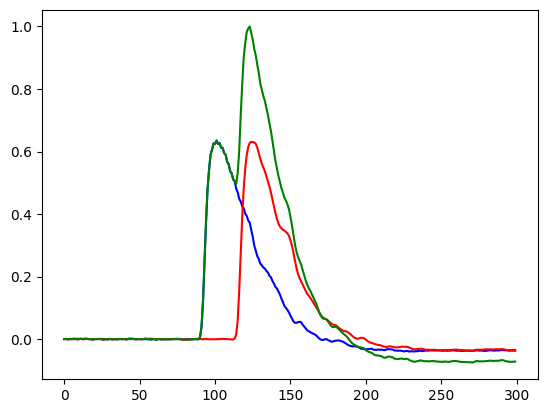

In [79]:
ittttt = 25
tt1 = traces_no_pileup[ittttt]
tt2 = traces_no_pileup[ittttt+1]
# print(tt1[:10],np.std(tt1[:10]))
rrp = 25.5 # in units of bins
newt,newa,newb = getRandomPileupTraces(tt1,tt2,rrp)
print(np.max(newt),np.min(newt))
print(np.min(newa),np.min(newb))
# newt = newt/np.max(newt)

# newt = traces_piledup[0][:,0]
# newa = traces_depiled[0][0][:]
# newb = traces_depiled[0][1][:]

# print(rrp)
plt.plot(newa,c='blue')
plt.plot(newb,c='red')
plt.plot(newt,c='green')

In [80]:
model = PulseNet()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
train_x = traces_piledup[:10000]
train_y = [phase_amplitude[:10000],traces_depiled[:10000]]
model.fit(train_x, train_y, epochs=NUMEPOCHS, batch_size=256, validation_split=0.2, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 1)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 237, 300)     19500       ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 2, 300)      0           ['conv1d_4[0][0]']               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 2, 150)       45150       ['max_pooling1d_4[0][0]']        
                                                                                            

In [81]:
test_x = traces_piledup[100000:110000]
test_y = traces_depiled[100000:110000]
test_phase_amp = phase_amplitude[100000:110000]
test_y_hat = model.predict(test_x)
test_amp = test_phase_amp[:,1].reshape(-1,1)
residual = test_y_hat[0][:,1].reshape(-1,1) - test_amp
phi_res = test_y_hat[0][:,0].reshape(-1,1) - test_phase_amp[:,0].reshape(-1,1)

313/313 [==============================] - 2s 5ms/step


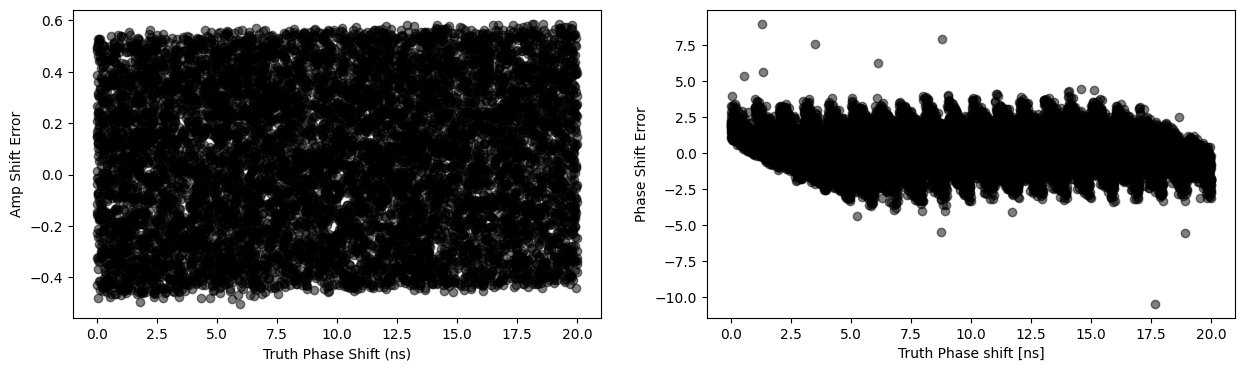

In [82]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2 ,figsize=(15, 4))
n = np.random.randint(0, test_x.shape[0])


# ax[0].plot(test_phase_amp[:,0], test_y_hat[0][:,0], 'o', color='black',alpha=0.5)
# ax[0].plot([0, 100], [0, 100], lw=2, color='red')
# ax[0].set_xlabel("True Phase Shift (ns)")
# ax[0].set_ylabel("Predicted Phase Shift (ns)")

# ax[1].plot(test_phase_amp[:,1], test_y_hat[0][:,1], 'o', color='black',alpha=0.5)
# ax[1].plot([0.5, 1.5], [0.5, 1.5], lw=2, color='red')
# ax[1].set_xlabel("True Amplitude Shift")
# ax[1].set_ylabel("Predicted Amplitude Shift")

# ax[0].plot(test_phase_amp[:,0],test_phase_amp[:,1], 'o', color='black',alpha=0.5)
# ax[1].plot(test_y_hat[0][:,0],test_y_hat[0][:,1], 'o', color='red',alpha=0.5)
ax[0].plot(test_phase_amp[:,0], residual, 'o', color='black',alpha=0.5)
# ax[1].set_xlabel("Predicted Phase Shift (ns)")
# ax[1].set_ylabel("Predicted Amplitude Shift")
ax[0].set_xlabel("Truth Phase Shift (ns)")
ax[0].set_ylabel("Amp Shift Error")

ax[1].plot(test_phase_amp[:,0], phi_res, 'o', color='black',alpha=0.5)
ax[1].set_xlabel("Truth Phase shift [ns]")
ax[1].set_ylabel("Phase Shift Error")

plt.show()


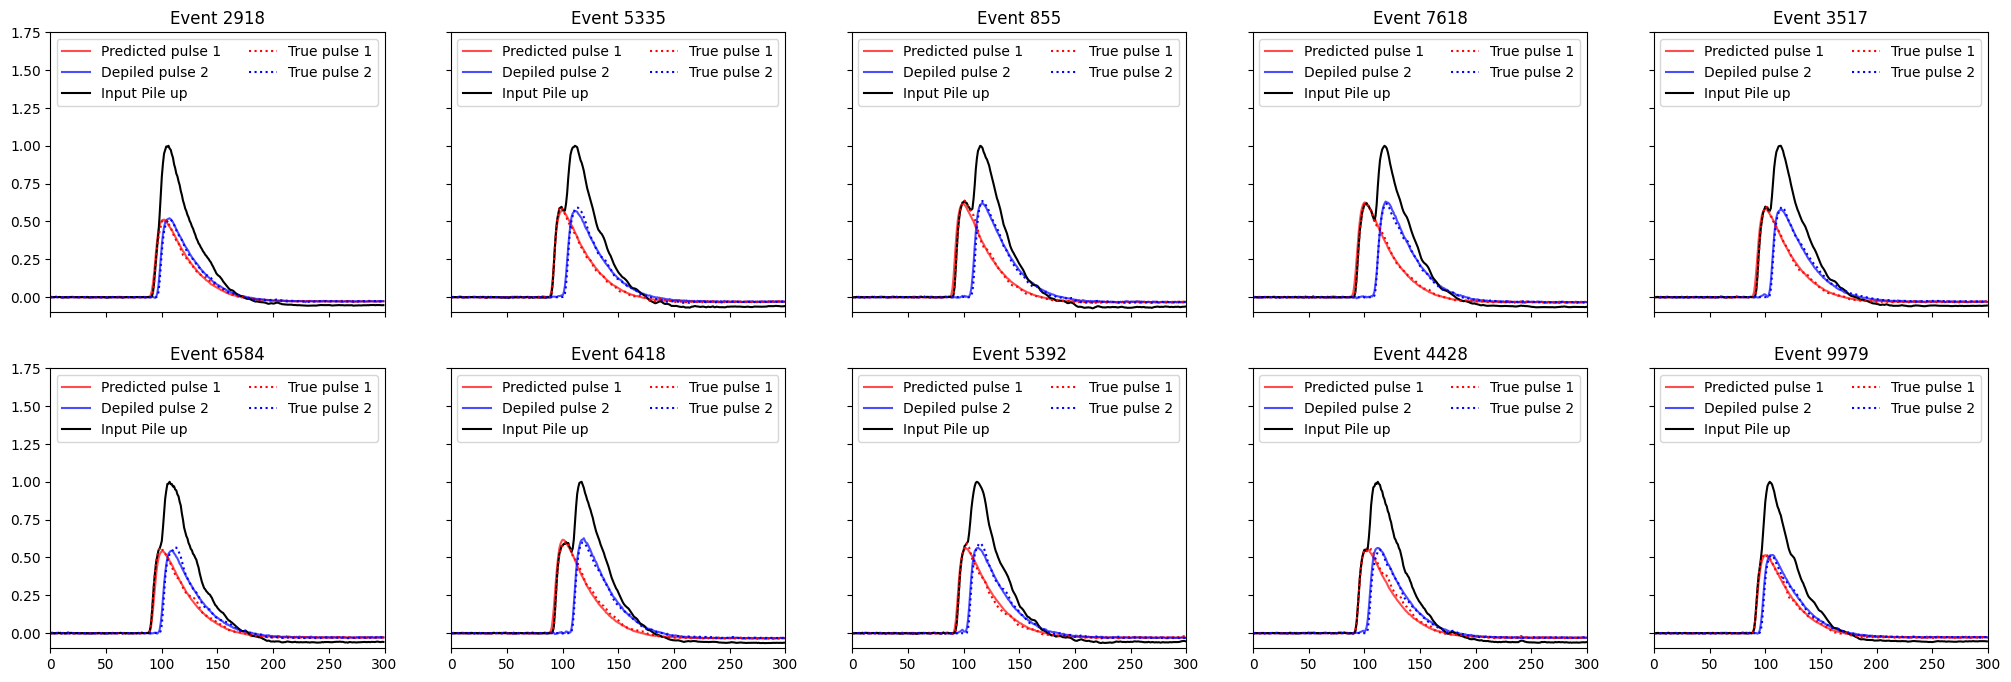

In [83]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5 ,figsize=(25, 8), sharex=True, sharey=True)
for i in range(10):
    n = np.random.randint(0, test_x.shape[0])
    # ax[i//5, i%5].plot(test_x[i][:,0], label="Pile up")
    ax[i//5, i%5].plot(test_y_hat[1][n][0][:], label="Predicted pulse 1", color='red',alpha=0.7)
    ax[i//5, i%5].plot(test_y_hat[1][n][1][:], label="Depiled pulse 2", color='blue',alpha=0.7)
    ax[i//5, i%5].plot(test_x[n][:,0], label="Input Pile up", color='black')
    ax[i//5, i%5].plot(test_y[n][0][:], label="True pulse 1", color='red', linestyle='dotted')
    ax[i//5, i%5].plot(test_y[n][1][:], label="True pulse 2", color='blue', linestyle='dotted')
    ax[i//5, i%5].set_title("Event {}".format(n))    
    ax[i//5, i%5].set_xlim(0, 300)
    ax[i//5, i%5].set_ylim(-0.1, 1.75)
    ax[i//5, i%5].legend( loc='upper right', ncol=2, fontsize=10)
    
plt.show()